## Task 4 - Modeling & Evaluation

### Summary

1. Poor F1 and recall scores due to imbalance classes. Target of interest is churn = 1.
2. Created a model after balancing classes gives better results in these metrics.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import shap

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from yellowbrick.classifier import ClassificationReport, DiscriminationThreshold

#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor
#from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor


%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.2)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif, f_regression, chi2

from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

np.random.seed(0)

from pycaret.classification import *
#from pycaret.clustering import *
#from pycaret.regression import *

pd.set_option('display.max_columns',100)
#pd.set_option('display.max_rows',100)
pd.set_option('display.width', 1000)
np.set_printoptions(suppress=True)

### Data Exploration and Analysis

In [2]:
df = pd.read_csv("final2.csv")

In [3]:
df

,cons_last_month,has_gas,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,duration,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,churn
0,10025,0,-41.76,-41.76,1,1732.36,3,180.000,1460.0,0.103449,0.092115,0.067241,58.956502,36.356887,8.337051,0
1,0,1,25.44,25.44,2,678.99,3,43.648,1096.0,0.122856,0.102137,0.072579,40.640023,24.384011,16.256008,1
2,0,0,16.38,16.38,1,18.89,6,13.800,2566.0,0.149934,0.000000,0.000000,44.315416,0.000000,0.000000,0
3,0,0,28.60,28.60,1,6.60,6,13.856,2192.0,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,0
4,0,0,30.22,30.22,1,25.46,6,13.200,2192.0,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16071,0,0,27.88,27.88,2,381.77,4,15.000,1445.0,0.144124,0.000000,0.000000,44.370635,0.000000,0.000000,0
16072,181,0,0.00,0.00,1,90.34,3,6.000,1461.0,0.106799,0.095406,0.070817,59.015674,36.393379,8.345418,1
16073,179,0,39.84,39.84,1,20.38,4,15.935,1460.0,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,1
16074,0,0,13.08,13.08,1,0.96,3,11.000,1461.0,0.149934,0.000000,0.000000,44.315416,0.000000,0.000000,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16076 entries, 0 to 16075
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cons_last_month       16076 non-null  int64  
 1   has_gas               16076 non-null  int64  
 2   margin_gross_pow_ele  16076 non-null  float64
 3   margin_net_pow_ele    16076 non-null  float64
 4   nb_prod_act           16076 non-null  int64  
 5   net_margin            16076 non-null  float64
 6   num_years_antig       16076 non-null  int64  
 7   pow_max               16076 non-null  float64
 8   duration              16076 non-null  float64
 9   price_p1_var          16076 non-null  float64
 10  price_p2_var          16076 non-null  float64
 11  price_p3_var          16076 non-null  float64
 12  price_p1_fix          16076 non-null  float64
 13  price_p2_fix          16076 non-null  float64
 14  price_p3_fix          16076 non-null  float64
 15  churn              

In [5]:
df.describe(include='all')

,cons_last_month,has_gas,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,duration,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,churn
count,1.607600e+04,16076.000000,16076.000000,16076.000000,16076.000000,16076.000000,16076.000000,16076.000000,16076.000000,16076.000000,16076.000000,16076.000000,16076.000000,16076.000000,16076.000000,16076.000000
mean,1.943471e+04,0.184188,22.470364,21.467969,1.347972,217.938200,5.029547,20.554866,2017.674981,0.141020,0.054343,0.030668,43.327651,10.680727,6.446303,0.099154
std,8.233817e+04,0.387649,23.701823,27.920127,1.460638,366.673412,1.675753,21.483703,627.076722,0.024297,0.049865,0.036217,5.357456,12.822437,7.761077,0.298878
min,-9.138600e+04,0.000000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,365.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,12.030000,11.950000,1.000000,51.985000,4.000000,12.500000,1461.000000,0.123981,0.000000,0.000000,40.675675,0.000000,0.000000,0.000000
50%,9.010000e+02,0.000000,21.090000,20.970000,1.000000,119.685000,5.000000,13.856000,1830.500000,0.147251,0.085885,0.000000,44.281745,0.000000,0.000000,0.000000
75%,4.124000e+03,0.000000,29.640000,29.640000,1.000000,275.772500,6.000000,19.800000,2401.000000,0.150317,0.102396,0.072778,44.370635,24.388455,16.248110,0.000000
max,4.538720e+06,1.000000,374.640000,374.640000,32.000000,24570.650000,16.000000,500.000000,5925.000000,0.278759,0.196275,0.102952,59.444710,36.490691,16.818917,1.000000


In [6]:
df.shape

(16076, 16)

In [7]:
df.columns

Index(['cons_last_month', 'has_gas', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act', 'net_margin', 'num_years_antig', 'pow_max', 'duration', 'price_p1_var', 'price_p2_var', 'price_p3_var', 'price_p1_fix', 'price_p2_fix', 'price_p3_fix', 'churn'], dtype='object')

### Data Visualization

### Univariate Data Exploration

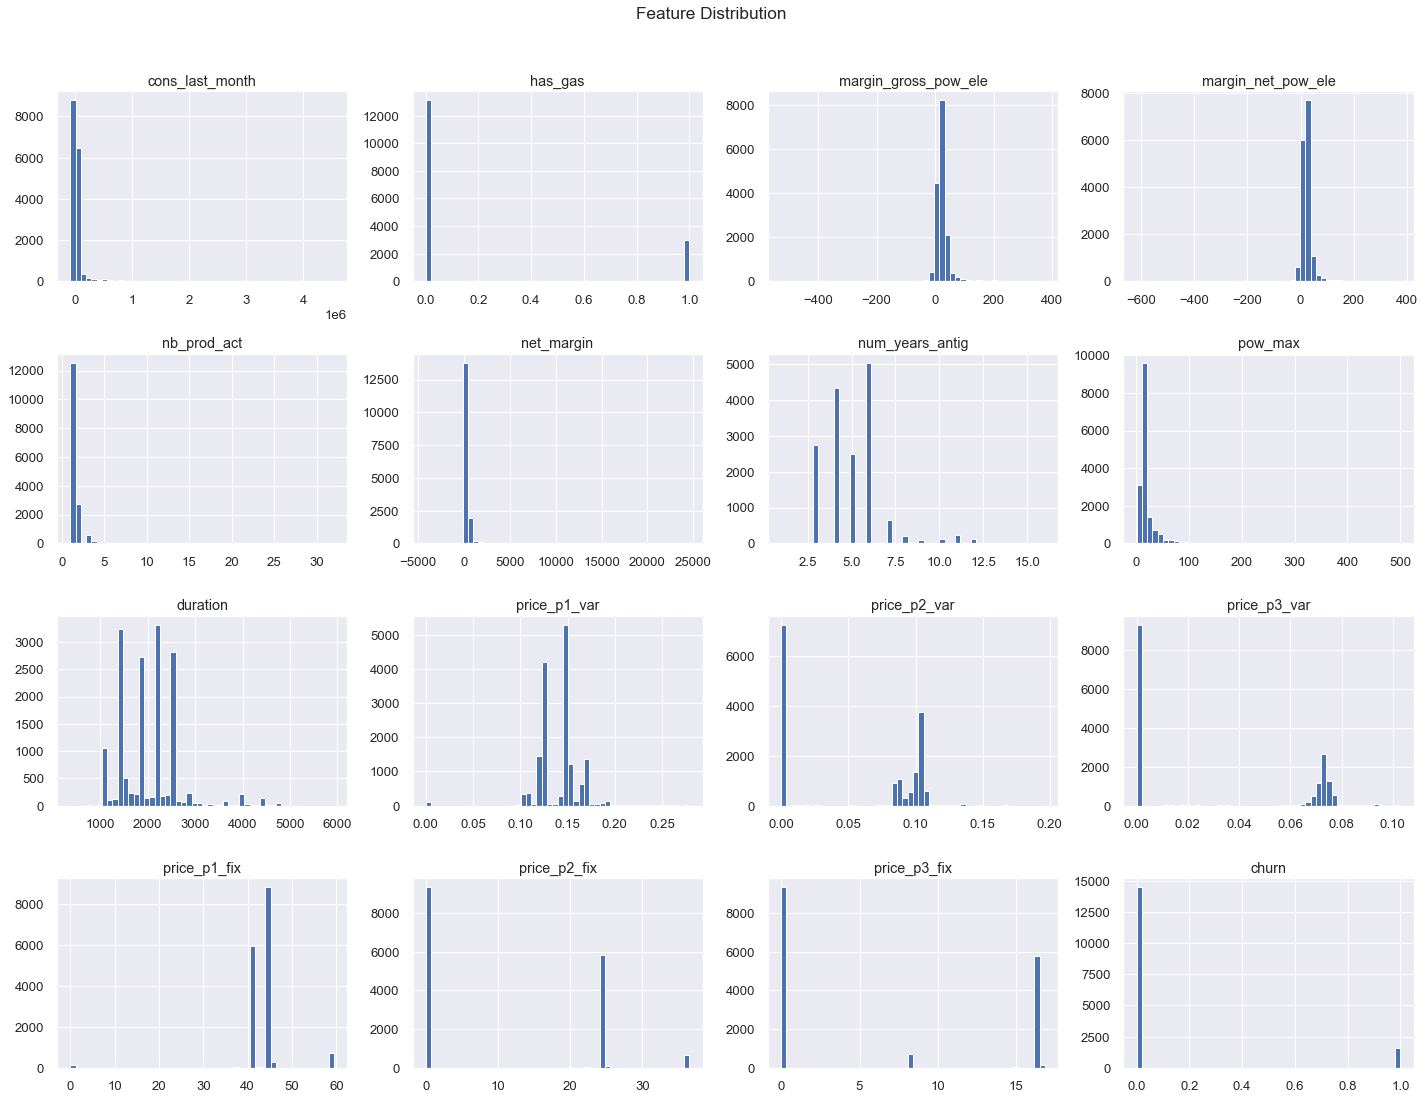

In [8]:
df.hist(bins=50, figsize=(20,15))
plt.suptitle('Feature Distribution', x=0.5, y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

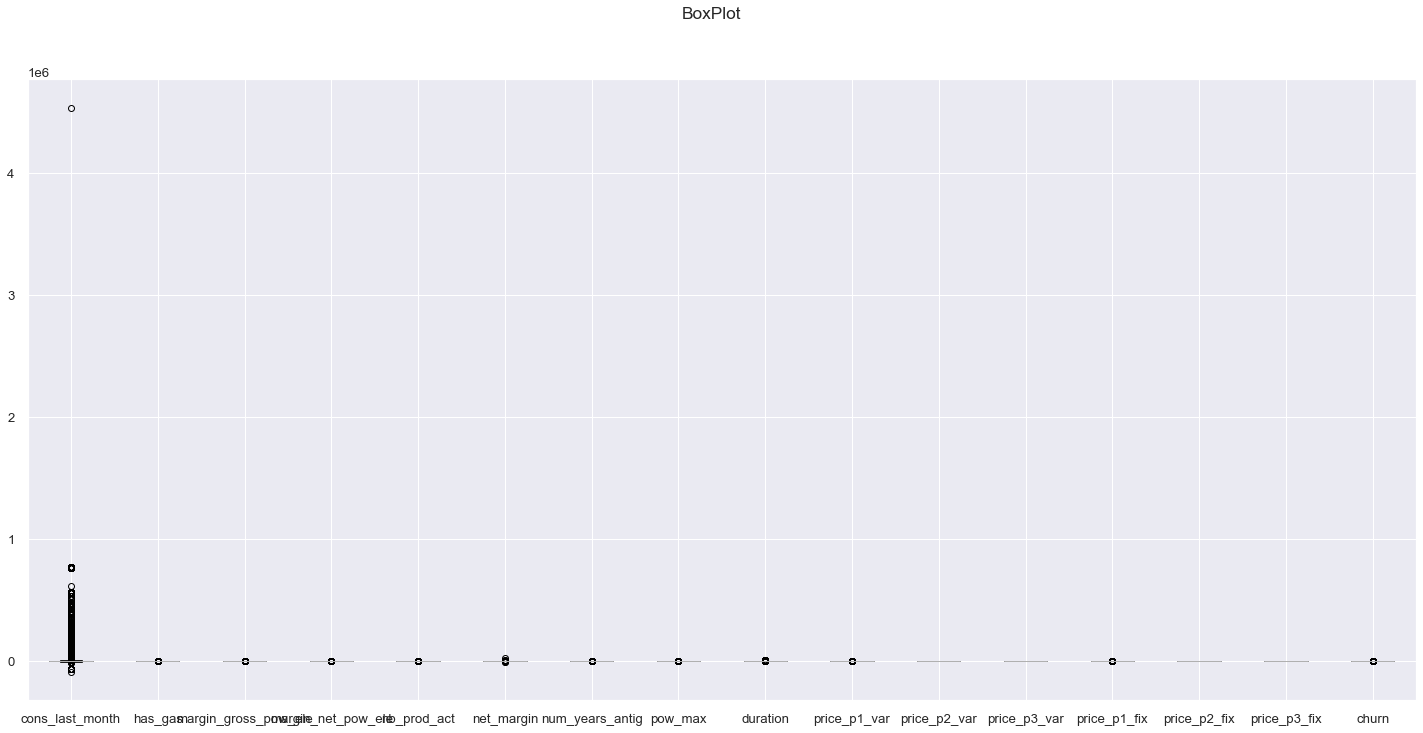

In [9]:
df.boxplot(figsize=(20,10))
plt.suptitle('BoxPlot', x=0.5, y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

### Correlation

In [10]:
df.corr()

,cons_last_month,has_gas,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,duration,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,churn
cons_last_month,1.000000,0.005240,-0.054205,-0.037766,0.351237,0.096491,0.004668,0.091558,-0.016011,-0.017634,0.121125,0.048831,-0.010839,0.051163,0.056681,-0.046830
has_gas,0.005240,1.000000,0.009682,0.004285,0.014025,-0.002258,-0.007612,-0.010297,-0.013632,0.006187,0.003688,0.006244,0.008890,0.005755,0.005278,0.007734
margin_gross_pow_ele,-0.054205,0.009682,1.000000,0.766458,-0.043861,-0.098432,-0.081287,-0.012871,-0.132225,0.174420,0.054795,0.075659,-0.127491,0.002869,0.107578,0.080280
margin_net_pow_ele,-0.037766,0.004285,0.766458,1.000000,-0.032268,-0.086216,-0.037702,-0.000556,-0.076409,0.031320,0.068608,0.089121,-0.137201,0.027399,0.115697,0.063282
nb_prod_act,0.351237,0.014025,-0.043861,-0.032268,1.000000,0.004580,0.009473,0.019150,0.002700,0.023988,0.025305,-0.003503,-0.007514,-0.009929,-0.000353,-0.022610
net_margin,0.096491,-0.002258,-0.098432,-0.086216,0.004580,1.000000,0.035457,0.457096,0.026245,-0.177704,0.253945,0.284003,0.015973,0.300371,0.267859,0.029452
num_years_antig,0.004668,-0.007612,-0.081287,-0.037702,0.009473,0.035457,1.000000,0.083967,0.958616,-0.219561,0.104251,0.085012,-0.050245,0.121350,0.067812,-0.072176
pow_max,0.091558,-0.010297,-0.012871,-0.000556,0.019150,0.457096,0.083967,1.000000,0.075596,-0.337367,0.346666,0.427225,0.068642,0.471785,0.393219,0.009913
duration,-0.016011,-0.013632,-0.132225,-0.076409,0.002700,0.026245,0.958616,0.075596,1.000000,-0.215336,0.091713,0.074261,-0.051749,0.110170,0.057034,-0.072692
price_p1_var,-0.017634,0.006187,0.174420,0.031320,0.023988,-0.177704,-0.219561,-0.337367,-0.215336,1.000000,-0.351049,-0.618786,0.418099,-0.652732,-0.592990,0.003167


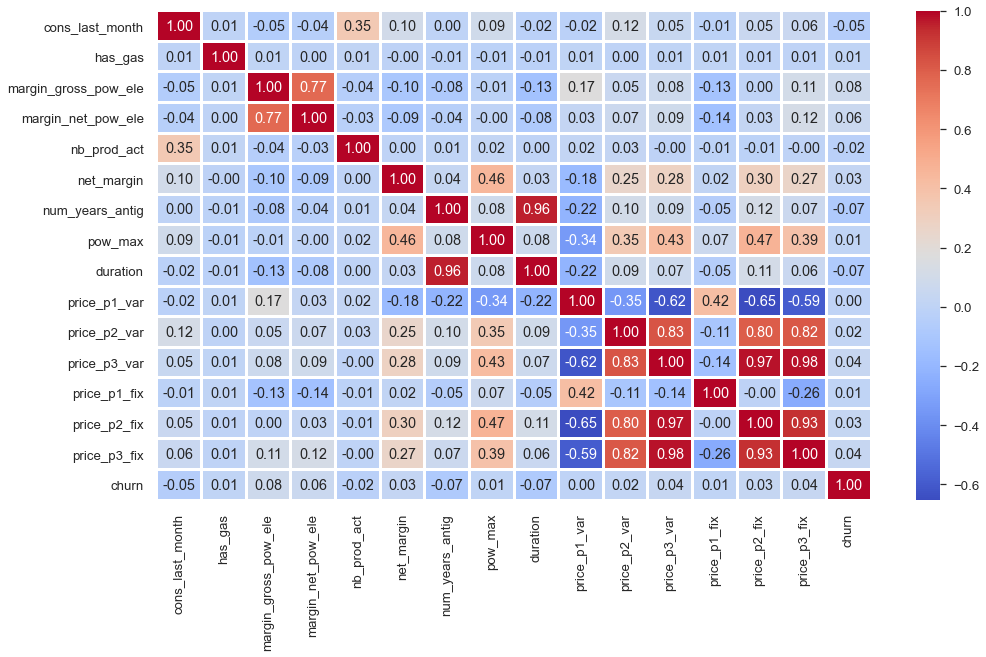

In [11]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

### Train Test Split

In [23]:
df.shape

(16076, 16)

In [24]:
X = df.iloc[:,0:15]
y = df.iloc[:,15]

### Treat Imbalance Data

In [25]:
y.value_counts()

0    14482
1     1594
Name: churn, dtype: int64

In [26]:
ros = RandomUnderSampler(sampling_strategy='majority',random_state=0)

In [27]:
new_X, new_y = ros.fit_resample(X, y)

In [28]:
new_y.value_counts()

1    1594
0    1594
Name: churn, dtype: int64

In [29]:
new_X

,cons_last_month,has_gas,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,duration,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
0,329,0,13.68,13.68,1,17.73,6,11.500,2557.0,0.148698,0.000000,0.000000,44.326190,0.000000,0.000000
1,0,0,21.78,21.78,1,56.33,6,13.200,2557.0,0.149865,0.000000,0.000000,44.406745,0.000000,0.000000
2,365,0,12.30,12.30,1,35.43,6,10.350,2557.0,0.146670,0.000000,0.000000,44.326190,0.000000,0.000000
3,2430,0,2.85,2.85,1,232.65,3,15.100,1461.0,0.126470,0.105770,0.075302,40.595592,24.357352,16.238235
4,243989,0,-3.15,-3.15,2,700.12,5,49.500,1827.0,0.118804,0.098377,0.069211,40.728885,24.437330,16.291555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3183,0,0,21.09,21.09,1,36.26,4,10.392,1827.0,0.150704,0.000000,0.000000,44.448412,0.000000,0.000000
3184,0,0,33.12,33.12,1,97.07,3,13.200,1461.0,0.150956,0.000000,0.000000,44.444710,0.000000,0.000000
3185,155,0,7.32,7.32,1,23.29,3,13.856,1481.0,0.146767,0.000000,0.000000,44.341005,0.000000,0.000000
3186,181,0,0.00,0.00,1,90.34,3,6.000,1461.0,0.106799,0.095406,0.070817,59.015674,36.393379,8.345418


### Train Test Split Cont'd

In [30]:
#X.values, y.values

In [31]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [32]:
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

### For balanced classes

In [33]:
new_X.values, new_y.values

(array([[329.        ,   0.        ,  13.68      , ...,  44.32619046,
           0.        ,   0.        ],
        [  0.        ,   0.        ,  21.78      , ...,  44.40674536,
           0.        ,   0.        ],
        [365.        ,   0.        ,  12.3       , ...,  44.32619046,
           0.        ,   0.        ],
        ...,
        [155.        ,   0.        ,   7.32      , ...,  44.34100546,
           0.        ,   0.        ],
        [181.        ,   0.        ,   0.        , ...,  59.01567351,
          36.3933792 ,   8.34541784],
        [179.        ,   0.        ,  39.84      , ...,  40.7017324 ,
          24.42103848,  16.28069392]]),
 array([0, 0, 0, ..., 1, 1, 1], dtype=int64))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(new_X.values, new_y.values, test_size=0.2, random_state=0)

In [35]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2550, 15), (638, 15), (2550,), (638,))

### Feature Scaling

In [36]:
X_train

array([[  928.        ,     1.        ,    13.26      , ...,
           44.36507876,     0.        ,     0.        ],
       [ 1324.        ,     0.        ,    19.2       , ...,
           44.37063536,     0.        ,     0.        ],
       [    0.        ,     0.        ,    19.2       , ...,
           44.37063516,     0.        ,     0.        ],
       ...,
       [  420.        ,     1.        ,    46.74      , ...,
           40.6474275 ,    24.38845514,    16.25897136],
       [    0.        ,     0.        ,    21.92      , ...,
           44.54655996,     0.        ,     0.        ],
       [13951.        ,     1.        ,    -0.24      , ...,
           40.5659715 ,    24.33957914,    16.22638536]])

In [37]:
scaler = StandardScaler()

In [38]:
X_train_scaled = scaler.fit_transform(X_train)

In [39]:
X_test_scaled = scaler.transform(X_test)

In [40]:
X_train_scaled

array([[-0.22945191,  2.10919841, -0.38025155, ...,  0.2153079 ,
        -0.87572829, -0.87361503],
       [-0.22340421, -0.47411376, -0.18320252, ...,  0.21658191,
        -0.87572829, -0.87361503],
       [-0.24362428, -0.47411376, -0.18320252, ...,  0.21658187,
        -0.87572829, -0.87361503],
       ...,
       [-0.23721006,  2.10919841,  0.73038844, ..., -0.63707063,
         1.02995854,  1.19687481],
       [-0.24362428, -0.47411376, -0.09297132, ...,  0.25691769,
        -0.87572829, -0.87361503],
       [-0.03056522,  2.10919841, -0.82809026, ..., -0.65574676,
         1.02613942,  1.19272517]])

In [41]:
X_test_scaled

array([[-0.24362428, -0.47411376,  0.27856895, ...,  0.19280454,
        -0.87572829, -0.87361503],
       [-0.23055149, -0.47411376, -0.04387492, ..., -0.64329601,
         1.0286855 ,  1.1954916 ],
       [-0.24362428, -0.47411376,  0.08019298, ...,  0.22337542,
        -0.87572829, -0.87361503],
       ...,
       [-0.24362428, -0.47411376, -0.22035655, ...,  0.25691778,
        -0.87572829, -0.87361503],
       [ 1.63325331, -0.47411376, -0.61511808, ...,  0.19280456,
        -0.87572829, -0.87361503],
       [-0.2404019 , -0.47411376, -0.10624061, ...,  0.21318512,
        -0.87572829, -0.87361503]])

### Model Training

### Using PyCaret

In [12]:
exp = setup(data = df, target = 'churn', session_id=0, normalize=True, train_size=0.8, fix_imbalance=False) 

,Description,Value
0,session_id,0
1,Target,churn
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(16076, 16)"
5,Missing Values,False
6,Numeric Features,12
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [13]:
compare_models(exclude=['catboost','lightgbm','lda','qda','mlp','nb','ridge'],fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9023,0.6633,0.0482,0.6523,0.0896,0.0770,0.1583,0.9220
xgboost,Extreme Gradient Boosting,0.9009,0.6631,0.0894,0.5261,0.1526,0.1273,0.1864,1.5920
lr,Logistic Regression,0.8995,0.6210,0.0016,0.1400,0.0031,0.0014,0.0078,1.5760
ada,Ada Boost Classifier,0.8994,0.6444,0.0062,0.3967,0.0122,0.0086,0.0370,0.5140
gbc,Gradient Boosting Classifier,0.8993,0.6611,0.0093,0.3645,0.0182,0.0133,0.0443,1.7480
svm,SVM - Linear Kernel,0.8981,0.0000,0.0093,0.0996,0.0170,0.0102,0.0167,0.0900
et,Extra Trees Classifier,0.8929,0.6315,0.0770,0.3466,0.1256,0.0924,0.1233,0.7740
knn,K Neighbors Classifier,0.8921,0.5676,0.0552,0.2974,0.0928,0.0632,0.0898,0.5380
dt,Decision Tree Classifier,0.8233,0.5514,0.2115,0.1779,0.1932,0.0948,0.0953,0.1300


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [14]:
rf = create_model('rf', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9036,0.6749,0.0506,0.7647,0.0949,0.0835,0.1808
1,0.9032,0.6520,0.0623,0.6667,0.1139,0.0985,0.1834
2,0.9012,0.6607,0.0350,0.6000,0.0662,0.0558,0.1277
3,0.9016,0.6639,0.0428,0.6111,0.0800,0.0678,0.1431
4,0.9016,0.6648,0.0504,0.6190,0.0932,0.0793,0.1567
Mean,0.9023,0.6633,0.0482,0.6523,0.0896,0.0770,0.1583
SD,0.0009,0.0074,0.0091,0.0606,0.0159,0.0145,0.0215


In [15]:
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [16]:
tuned_rf = tune_model(rf, optimize='F1', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6108,0.6276,0.5837,0.1437,0.2306,0.0836,0.1206
1,0.6474,0.6105,0.4864,0.1389,0.2161,0.0718,0.0953
2,0.6299,0.6206,0.5564,0.1458,0.2310,0.0863,0.1200
3,0.7026,0.6332,0.4591,0.1586,0.2358,0.1024,0.1248
4,0.7033,0.6358,0.4884,0.1664,0.2483,0.1160,0.1422
Mean,0.6588,0.6255,0.5148,0.1507,0.2323,0.0920,0.1206
SD,0.0379,0.0092,0.0471,0.0102,0.0103,0.0155,0.0150


In [17]:
print(tuned_rf)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=4, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.001, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


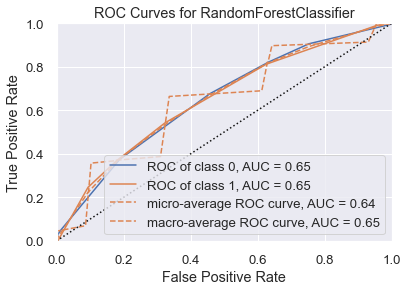

In [18]:
plot_model(tuned_rf)

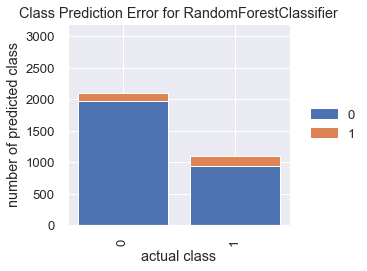

In [19]:
plot_model(tuned_rf, plot = 'error')

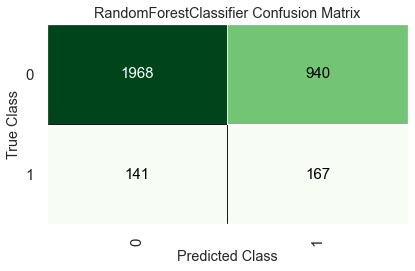

In [20]:
plot_model(tuned_rf, plot = 'confusion_matrix')

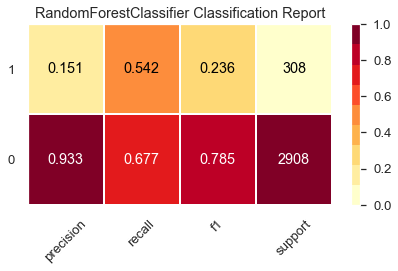

In [21]:
plot_model(tuned_rf, plot = 'class_report')

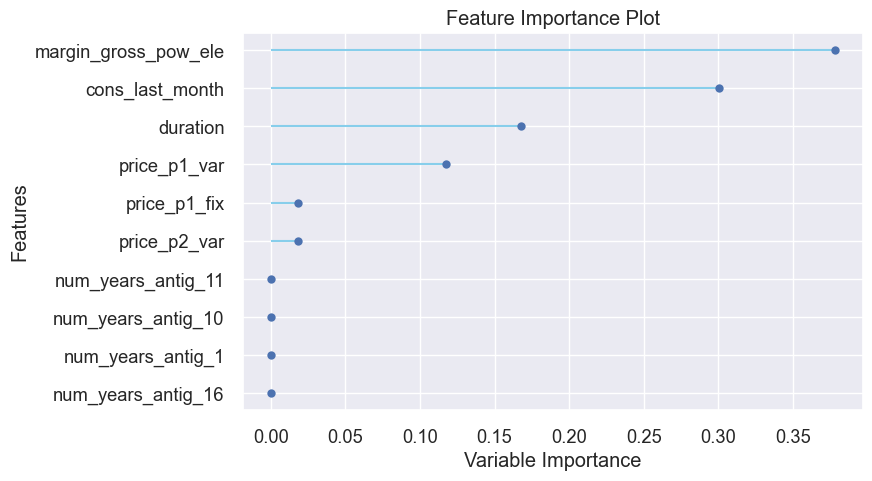

In [22]:
plot_model(tuned_rf, plot='feature')

### Using Regression or Classification Models

### Using XGBoost (Scikit-Learn)

### Using RandomSearchCV

In [42]:
model = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [43]:
parameters = {'max_depth': np.arange(3,10,1),
              'eta': np.arange(0.05,0.3,0.05),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,10,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1),
              'reg_alpha':np.arange(0,1,0.1),
              'reg_lambda':np.arange(0,1,0.1)
             }

In [44]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 10, 
                           n_jobs=-1, scoring='f1')

In [45]:
randm.fit(new_X,new_y)

[13:57:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n...
                                        'min_child_weight': array([1, 2, 3]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800,

In [46]:
randm.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eta=0.05, gamma=8,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0500000007, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=800, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0,
              reg_alpha=0.6000000000000001, reg_lambda=0.6000000000000001,
              scale_pos_weight=1, subsample=0.7999999999999999,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [47]:
randm.best_score_

0.6233047729973467

In [48]:
randm.best_params_

{'subsample': 0.7999999999999999,
 'reg_lambda': 0.6000000000000001,
 'reg_alpha': 0.6000000000000001,
 'n_estimators': 800,
 'min_child_weight': 1,
 'max_depth': 8,
 'gamma': 8,
 'eta': 0.05,
 'colsample_bytree': 0.6}

### Final Model

In [49]:
xgbmodel = XGBClassifier(random_state=0, n_estimators=800, objective='binary:logistic',eta=0.05,colsample_bytree=0.6,
                        subsample=0.8,reg_lambda=0.6,reg_alpha=0.6,min_child_weight=1,max_depth=8,gamma=8)

In [50]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='logloss',early_stopping_rounds=10)

[0]	validation_0-logloss:0.69037
[1]	validation_0-logloss:0.68638
[2]	validation_0-logloss:0.68404
[3]	validation_0-logloss:0.68257
[4]	validation_0-logloss:0.68183
[5]	validation_0-logloss:0.67988
[6]	validation_0-logloss:0.67819
[7]	validation_0-logloss:0.67602
[8]	validation_0-logloss:0.67371
[9]	validation_0-logloss:0.67186
[10]	validation_0-logloss:0.67061
[11]	validation_0-logloss:0.66937
[12]	validation_0-logloss:0.66754
[13]	validation_0-logloss:0.66597
[14]	validation_0-logloss:0.66438
[15]	validation_0-logloss:0.66311
[16]	validation_0-logloss:0.66275
[17]	validation_0-logloss:0.66068
[18]	validation_0-logloss:0.65958
[19]	validation_0-logloss:0.65879
[20]	validation_0-logloss:0.65841
[21]	validation_0-logloss:0.65821
[22]	validation_0-logloss:0.65711
[23]	validation_0-logloss:0.65677
[24]	validation_0-logloss:0.65605
[25]	validation_0-logloss:0.65559
[26]	validation_0-logloss:0.65465
[27]	validation_0-logloss:0.65281
[28]	validation_0-logloss:0.65255
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eta=0.05, gamma=8,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0500000007, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=800, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0.6,
              reg_lambda=0.6, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [51]:
y_pred = xgbmodel.predict(X_test_scaled)

In [52]:
y_pred

array([1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,

### Model Evaluation

In [53]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[215, 113],
       [126, 184]], dtype=int64)

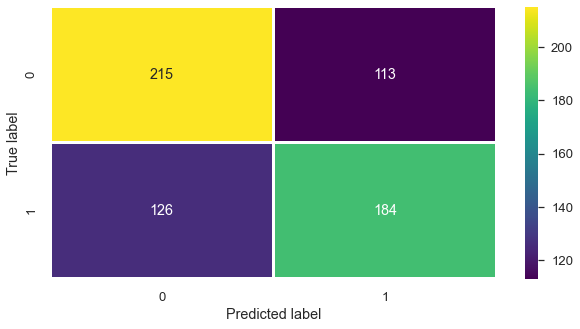

In [54]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [55]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.63      0.66      0.64       328
           1       0.62      0.59      0.61       310

    accuracy                           0.63       638
   macro avg       0.63      0.62      0.62       638
weighted avg       0.63      0.63      0.63       638



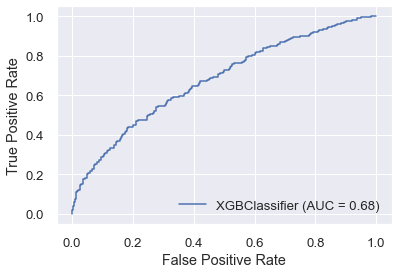

In [56]:
plot_roc_curve(xgbmodel,X_test_scaled,y_test)
plt.show()

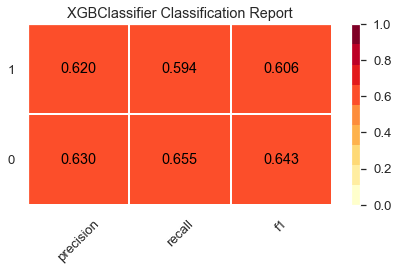

<AxesSubplot:title={'center':'XGBClassifier Classification Report'}>

In [57]:
visualizer = ClassificationReport(model=xgbmodel)
visualizer.fit(X_train_scaled,y_train)
visualizer.score(X_test_scaled,y_test)
visualizer.show()

[14:01:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:01:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:01:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:01:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

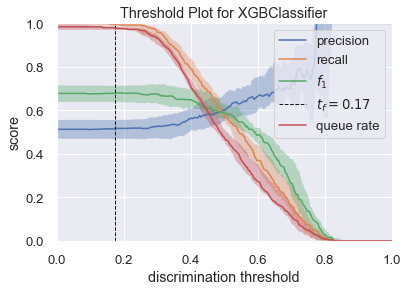

<Figure size 1152x648 with 0 Axes>

<AxesSubplot:title={'center':'Threshold Plot for XGBClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [58]:
visualizer = DiscriminationThreshold(model=xgbmodel, random_state=0, n_trials=10)
visualizer.fit(X_train_scaled,y_train)
visualizer.score(X_test_scaled,y_test)
plt.figure(figsize=(16,9))
visualizer.show()

### The permutation based importance

In [59]:
perm_importance = permutation_importance(xgbmodel,X_test_scaled,y_test, random_state=0, scoring='f1')

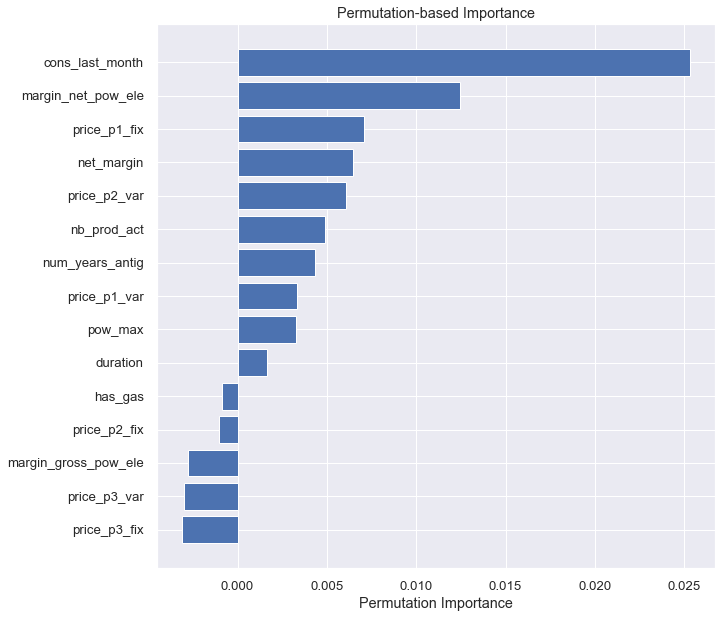

In [60]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10,10))
plt.title("Permutation-based Importance")
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

### Compute Importance from SHAP Values

In [61]:
explainer = shap.TreeExplainer(xgbmodel)

In [63]:
shap_values = explainer.shap_values(X_test_scaled)

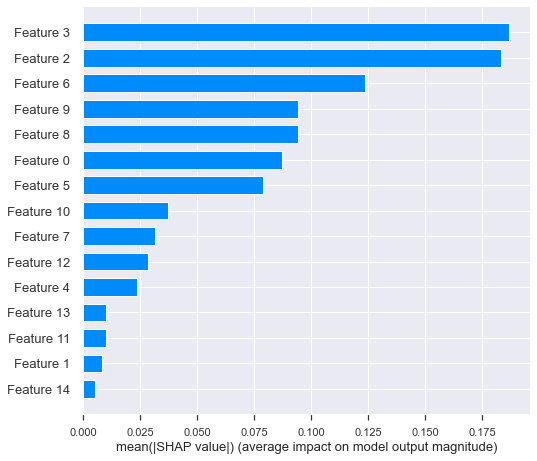

In [64]:
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")

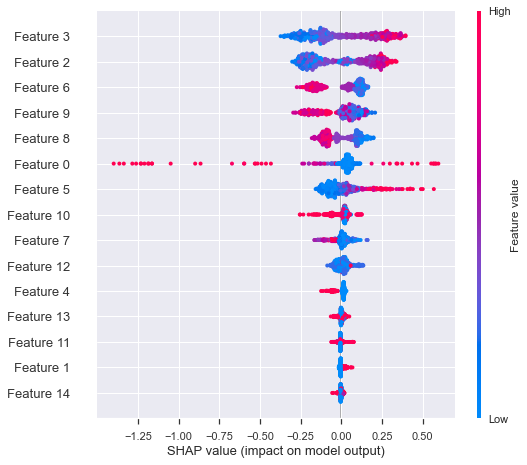

In [65]:
shap.summary_plot(shap_values, X_test_scaled)

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [66]:
new_X.columns

Index(['cons_last_month', 'has_gas', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act', 'net_margin', 'num_years_antig', 'pow_max', 'duration', 'price_p1_var', 'price_p2_var', 'price_p3_var', 'price_p1_fix', 'price_p2_fix', 'price_p3_fix'], dtype='object')

In [67]:
xgbmodel.get_booster().feature_names = ['cons_last_month', 'has_gas', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act', 'net_margin', 'num_years_antig', 'pow_max', 'duration', 'price_p1_var', 'price_p2_var', 'price_p3_var', 'price_p1_fix', 'price_p2_fix', 'price_p3_fix']

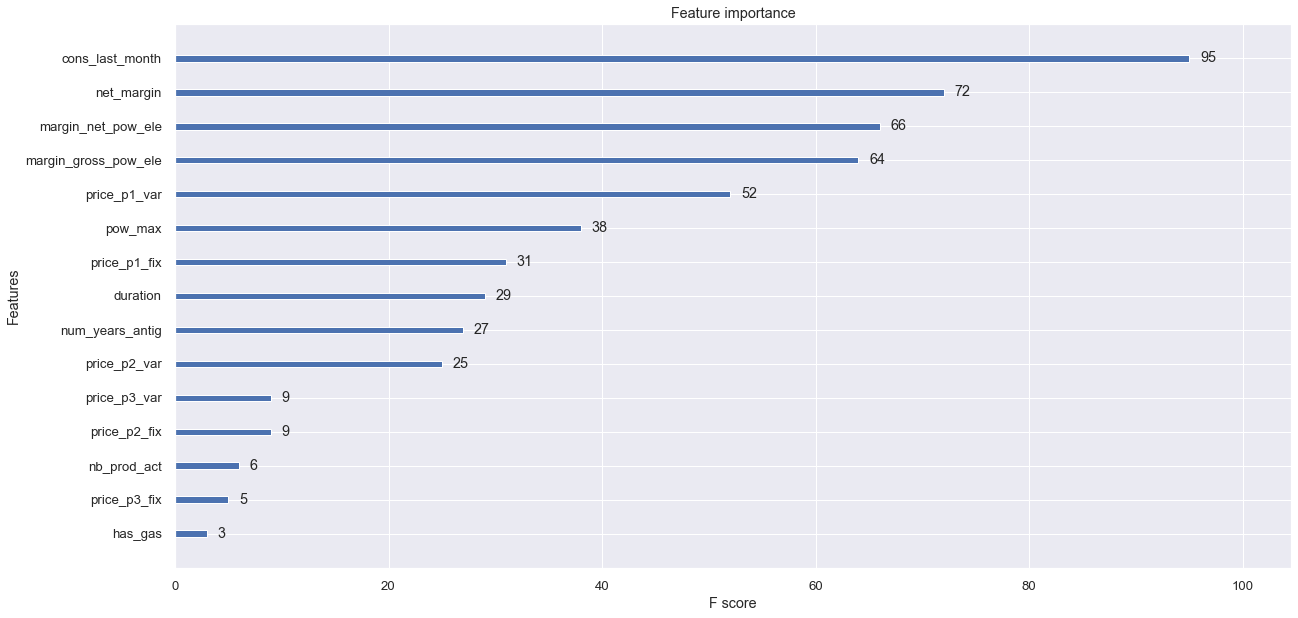

In [68]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

### Cross-Validation

In [70]:
cv = cross_val_score(xgbmodel,new_X,new_y,cv=5,verbose=1,scoring='f1')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[14:03:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.4s finished


In [71]:
cv.mean()

0.6233047729973467